In [1]:
import os
from Utils.utils import custom_plot
from Utils.StegoSet import StegoSet
from os import listdir
from os.path import isfile, join
from Algorithms.PM1 import insert_message_PM1, extract_message_PM1
from Algorithms.iPM1 import insert_message_iPM1
from Algorithms.AddEmb import insert_message_AddEmb, extract_message_AddEmb, dist_func, get_capacity, embed_message_into_block, get_message_from_block
import numpy as np
from Utils.utils import cut_image_into_blocks, get_dct_coefs, quantize_dct_blocks, qm, get_image_from_dct_coefs, concatenate_image, PSNR, dequantize_dct_blocks
from Utils.utils import count_BER, dct2d, idct2d
from Algorithms.StegoAlgorithm import StegoAlgorithm as algo
from Utils.Experimenter import Experimenter
import matplotlib.pyplot as plt
import copy
import cv2

In [2]:
mypath = os.getcwd() + "/images/grey/"
onlyfiles = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove(mypath + '.DS_Store')

my_set = StegoSet(onlyfiles, init_way='files')

In [3]:
def insert_message_iAddEmb(image, message, k=8, threshold=10):
    l = len(message)

    #step1
    blocks = cut_image_into_blocks(image)
    dct_blocks = quantize_dct_blocks(get_dct_coefs(blocks))
    
    #step2
    b_vector = dct_blocks.reshape(4096, 8, 8)
    
    n = len(b_vector[0])
    num_blocks = len(dct_blocks)

    #step3
    Q = [[] for _ in range(n)]
    for i in range(num_blocks):
        u = i // n
        v = i %  n
        Q[u].append(dist_func(u, v, b_vector))
    
    #step4
    k_coords = []
    for i in range(n):
        for j in range(n):
            k_coords.append([i, j])
    
    k_mins = sorted(k_coords, key=lambda x: Q[x[0]][x[1]])

    embedding_positions = k_mins[:k]
    cap = get_capacity(embedding_positions, b_vector)

    if cap >= l:
        point = 0
        for idx in range(len(b_vector)):
            t = 0
            cur_ber = 1
            best_ber = 1
            
            temp_point = point
            best_point = temp_point

            temp_b = b_vector[idx]
            best_b = copy.deepcopy(temp_b)

            while t < threshold and cur_ber != 0:
                temp_point, temp_b = embed_message_into_block(point, message, embedding_positions, temp_b)
                old_mes = message[point:temp_point]
                new_mes, _, _ = get_message_from_block([], embedding_positions, dct2d(idct2d(temp_b*qm))/qm, temp_point-point)
                
                if len(old_mes) > 0:
                    cur_ber = count_BER(old_mes, new_mes)

                    if cur_ber < best_ber:
                        best_ber = cur_ber
                        best_b = copy.deepcopy(temp_b)
                        best_point = temp_point
                t+=1
            
            point = best_point
            b_vector[idx] = best_b
            if point >= l:
                break

        new_image = concatenate_image(get_image_from_dct_coefs(dequantize_dct_blocks(b_vector.reshape(64, 64, 8, 8))))
        return new_image, {'route': embedding_positions, 'mes_len':l}
    else:
        raise RuntimeError("Capacity {} can't fit the message with size {}".format(cap, l))

In [4]:
m = np.random.randint(1, 2, 18000)
for im in my_set:
    im_old, params_old = insert_message_AddEmb(im, m, k=8)
    im_new, params_new = insert_message_iAddEmb(im, m, k=8)
    mes_old = extract_message_AddEmb(im_old, **params_old)
    mes_new = extract_message_AddEmb(im_new, **params_new)
    print("Ber_old = {}, Ber_new = {}".format(count_BER(m, mes_old), count_BER(m, mes_new)))

Ber_old = 0.00011111111111111112, Ber_new = 0.00011111111111111112
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.0014444444444444444, Ber_new = 0.0014444444444444444
Ber_old = 0.0002777777777777778, Ber_new = 0.0002777777777777778
Ber_old = 0.00016666666666666666, Ber_new = 0.00016666666666666666
Ber_old = 5.555555555555556e-05, Ber_new = 5.555555555555556e-05
Ber_old = 0.002, Ber_new = 0.002
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.0006111111111111111, Ber_new = 0.0006111111111111111
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.0022222222222222222, Ber_new = 0.0022222222222222222
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.001, Ber_new = 0.001
Ber_old = 5.555555555555556e-05, Ber_new = 5.555555555555556e-05
Ber_old = 0.0003333333333333333, Ber_new = 0.0003333333333333333
Ber_old = 0.0008888888888888889, Ber_new = 0.0008888888888888889
Ber_old = 0.0, Ber_new = 0.0
Ber_old = 0.0, Ber_new = 0.0


In [5]:
AE = algo(insert_message_AddEmb, extract_message_AddEmb)
iAE = algo(insert_message_iAddEmb, extract_message_AddEmb)

exp_normal = Experimenter(my_set, AE, MAX_VALUE=18000)
exp_iter = Experimenter(my_set, iAE, MAX_VALUE=18000)
exp_normal.make_experiment()
exp_iter.make_experiment()

1800
3600
5400
7200
9000
10800
12600
14400
16200
18000
1800
3600
5400
7200
9000
10800
12600
14400
16200
18000


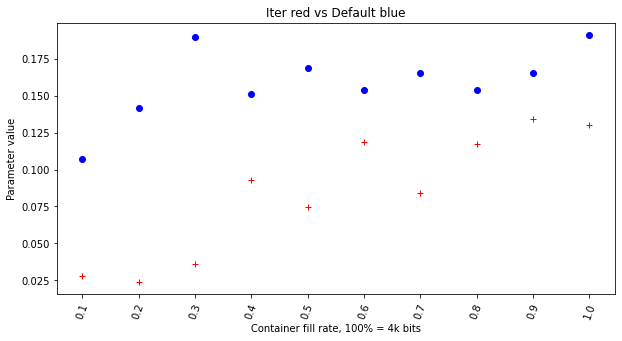

In [6]:
x_vals = exp_iter.percentages
plt.figure(figsize=(10, 5))

plt.plot(x_vals, exp_normal.ber_vals, 'bo', x_vals, exp_iter.ber_vals, 'r+')
plt.xlabel('Container fill rate, 100% = 4k bits')
plt.ylabel('Parameter value')
plt.xticks(x_vals, rotation = 70)
plt.title('Iter red vs Default blue')

plt.show()

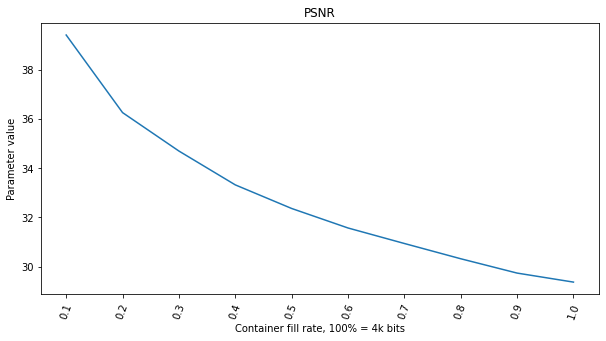

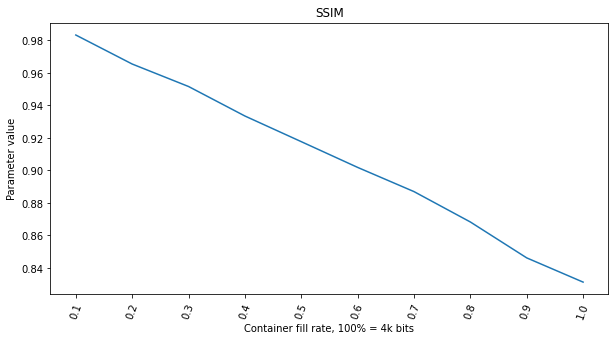

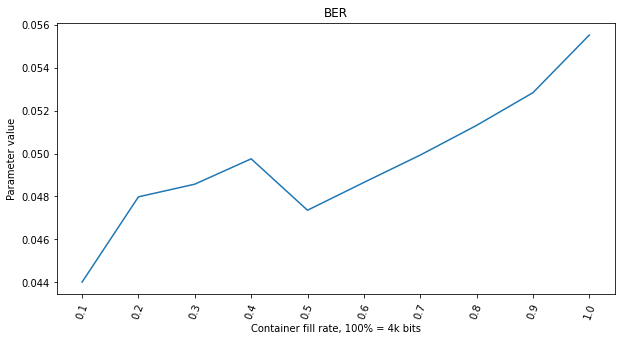

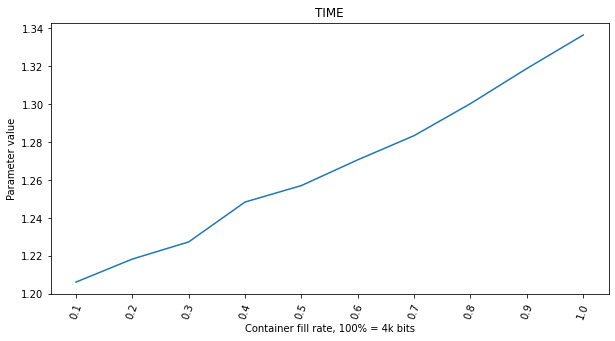

In [73]:
x_vals = exp_iter.percentages

data = {'PSNR': exp_iter.psnr_vals, 'SSIM': exp_iter.ssim_vals, 'BER': exp_iter.ber_vals, 'TIME': exp_iter.time_vals}

for d in data:
    plt.figure(figsize=(10, 5))
    custom_plot(x_vals, data[d])
    
    plt.xlabel('Container fill rate, 100% = 4k bits')
    plt.ylabel('Parameter value')
    plt.xticks(x_vals, rotation = 70)
    plt.title(d)
    
    plt.show()